## Introduction

ARIMA is one of the most classic time series forecasting models. During the modeling process, we mainly want to find 3 parameters. Auto-regression(AR) term, namly the lags of previous value; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term.  

I'm a newbie in this field. Found many online tutorials used grid search technique(auto.arima in R). Meanwhile I also found many hypothesis test to validate the time series, i.e. see if it's stationary, looking at ACF and PACF to suggest a AR term etc... 

Facebook has a package called prophet, which is quite complex and consider many things automaticlly. But out of curiosity, I want to understand what's the reasoning behind the model. ARIMA is definitely a good starting point.

### My goal for this notebook:
1. Understand ARIMA, SARIMA, ARIMAX  
2. Walkthrough the necessary tests that ARIMA needs to statisfy
3. Find a set of reasonable parameters base on a statistic tests and visualizations   

### Notebook Outline:
* ARIMA introduction  
* Decompose the ts
* Stationarize the data  
* Interpret ACF and PACF  
* Determine p, d, q
* Adding seasonality: S-ARMIA
* Adding holiday factors to be SARIMA-X


#### A few things on my TODO list:
- mulitple seasonality
- outlier detection

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm

color = sns.color_palette()
sns.set_style('darkgrid')


In [2]:
train = pd.read_csv('train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Forecast modeling - ARIMA

we want to start with some basic/classic model like armia. 
Here is a list of online tutorials that helps me get started:  
http://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/  
http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python

ARIMA model includes the AR term, the I term, and the MA term. Let’s actually start with the I term, as it is the easiest to explain. The I term is a full difference. That is today’s value minus yesterday’s value. That’s it.  
The way that I like to think of the AR term is that it is a partial difference. The coefficient on the AR term will tell you the percent of a difference you need to take.   
**MA**  
A moving average term in a time series model is a past error (multiplied by a coefficient).The label "moving average" is is somewhat misleading because the weights 1,−θ1,−θ2,…,−θq, which multiply the a's, need not total unity nor need that be positive.  
Xt=εt+θ1εt−1+⋯+θqεt−q  as akin to a weighted moving average of the ε terms,


In [3]:
# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head()


,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


## Decompose the time series
To start with, we want to decompose the data to seperate the seasonality, trend and residual. Since we have 5 years of sales data. We would expect there's a yearly or weekly pattern. Let's use a function in statsmodels to help us find it. 

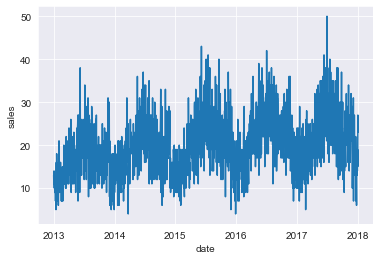

In [4]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

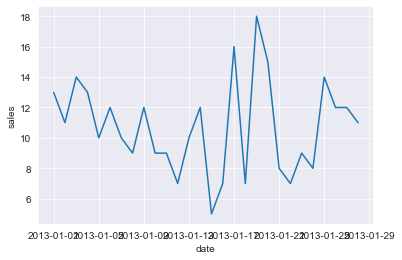

In [5]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

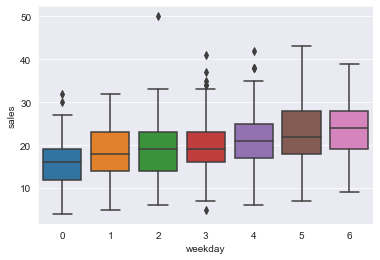

In [6]:
sns.boxplot(x="weekday", y="sales", data=train_df)

Monday=0, Sunday=6.  
Here we can find the weekends(5,6) has a larger sales, weekdays(0-4) are smaller. There's a few outliers on Monday, Wed.

In [7]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


In [8]:
print(train_df['sales'])

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
              ... 
2017-12-27    14.0
2017-12-28    19.0
2017-12-29    15.0
2017-12-30    27.0
2017-12-31    23.0
Name: sales, Length: 1826, dtype: float64


<Figure size 432x288 with 0 Axes>

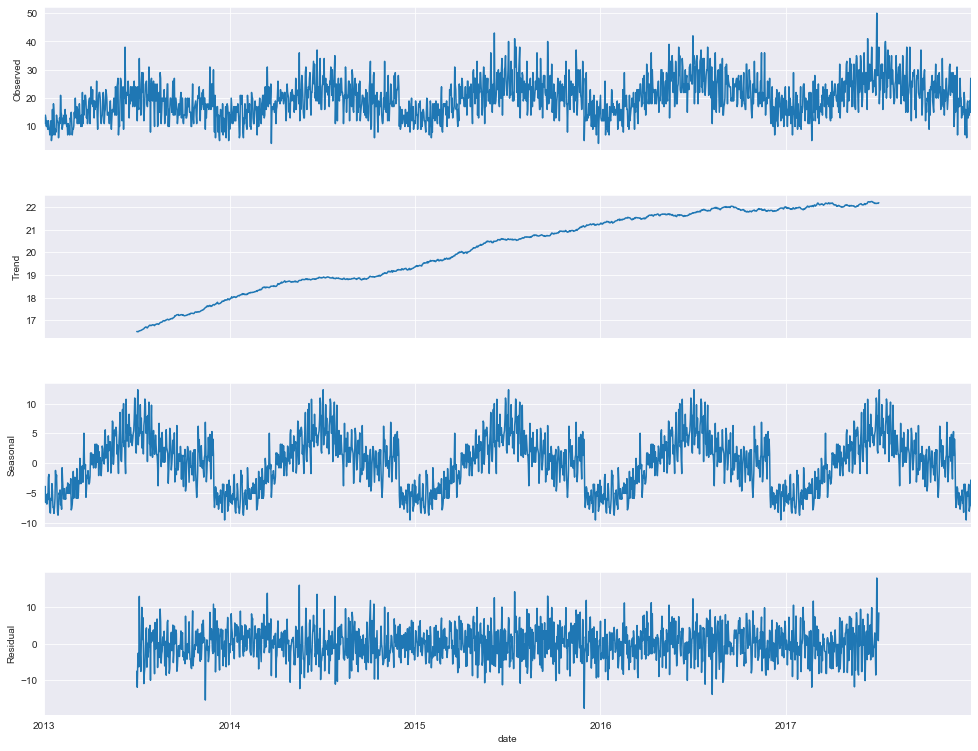

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

Playing with a few frequency, the yearly pattern is very obvious. and also we can see a upwards trend. Which means this data is not stationary.

###  Stationarize the data:

What does it mean for data to be stationary?

The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over time. 
![alt text](https://imgur.com/LjtBXwf.png)

The variance of the series should not be a function of time. This property is known as homoscedasticity. Notice in the red graph the varying spread of data over time. 
![alt text](https://imgur.com/v2Uye7X.png)

Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’. 
![Imgur](https://i.imgur.com/6HVlvg2.png)  
Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test. I won’t go into the specifics of this test, but if the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. Below is code that will help you visualize the time series and test for stationarity.



In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)


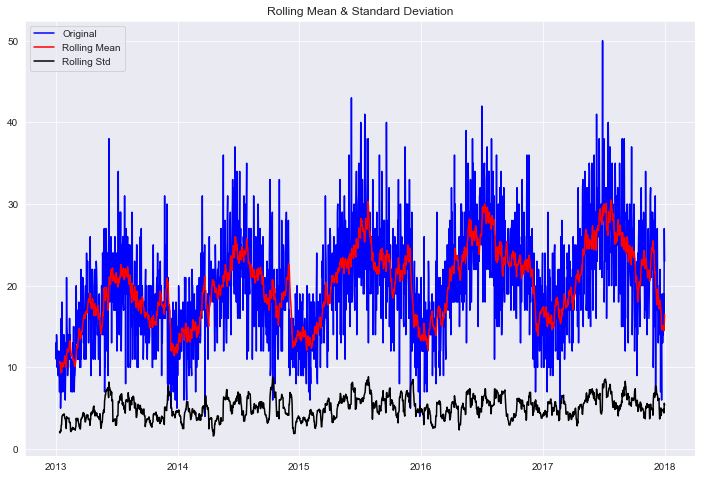

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [11]:
test_stationarity(train_df['sales'])

the smaller p-value, the more likely it's stationary. Here our p-value is 0.036. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.  
To get a stationary data, there's many techiniques. We can use log, differencing etc... 

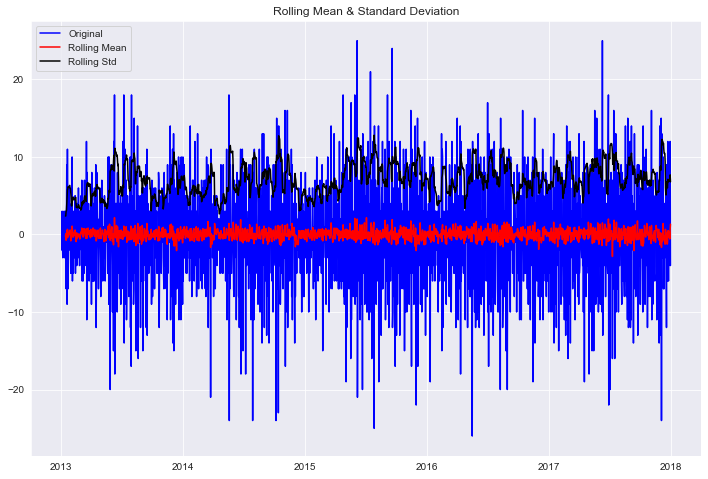

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [12]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.  


## ACF and PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.
### Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

### References:  
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/


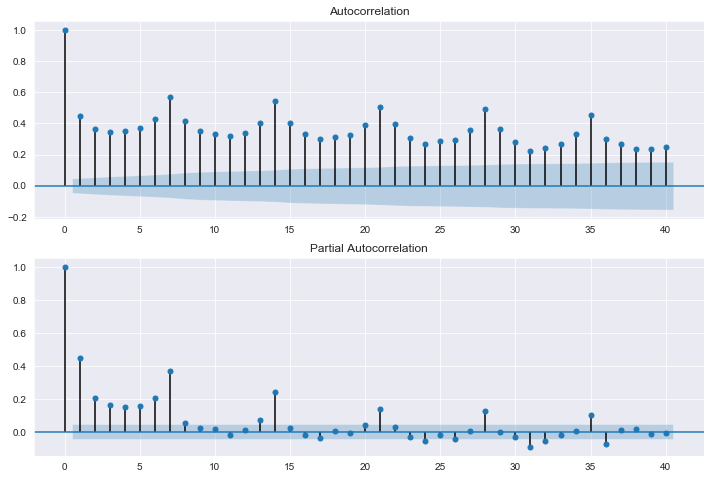

In [13]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

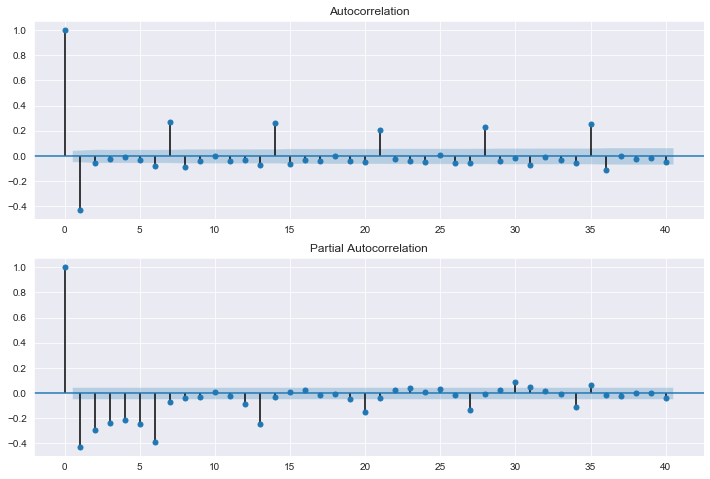

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.   
## Build the model

### How to determin p, d, q

It's easy to determin I. In our case, we see the first order differencing make the ts stationary. **I = 1**.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use ** AR = 6** 

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0),  it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.
### Reference:
https://www.researchgate.net/post/How_does_one_determine_the_values_for_ARp_and_MAq   
https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms/281726#281726  
https://stats.stackexchange.com/questions/134487/analyse-acf-and-pacf-plots?rq=1  

In [15]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Wed, 31 Jul 2019   AIC                          11211.335
Time:                        10:29:34   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

### Analyze the result
To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.

NormaltestResult(statistic=16.42638879596088, pvalue=0.0002710534841743061)


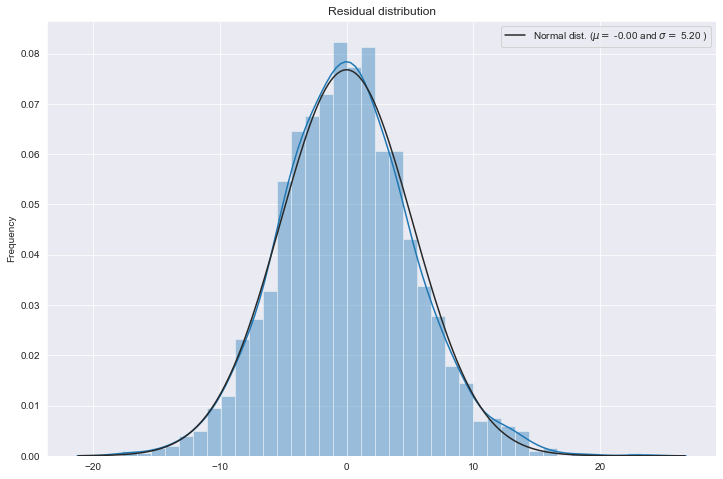

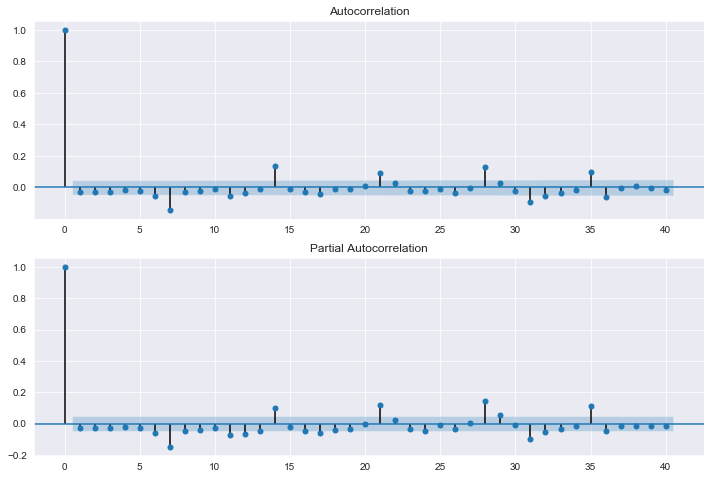

In [16]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

### Consider seasonality affect by SARIMA


https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html  
https://barnesanalytics.com/sarima-models-using-statsmodels-in-python

In [45]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
print(sarima_mod6.summary())

NameError: name 'exog_train' is not defined

NormaltestResult(statistic=14.522214330773977, pvalue=0.0007023300095074055)


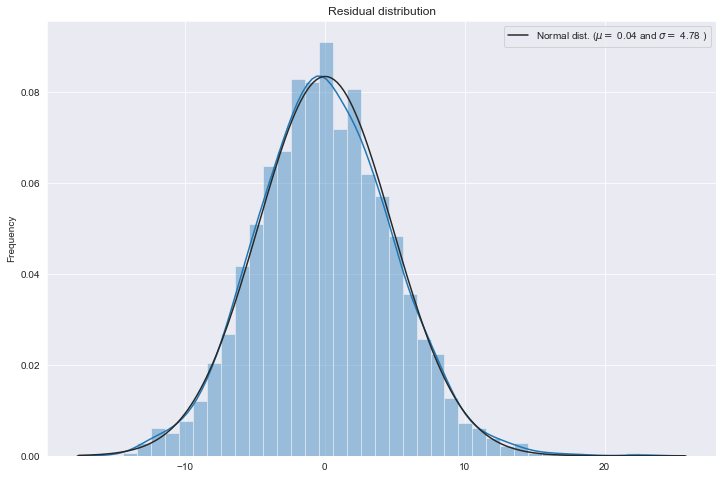

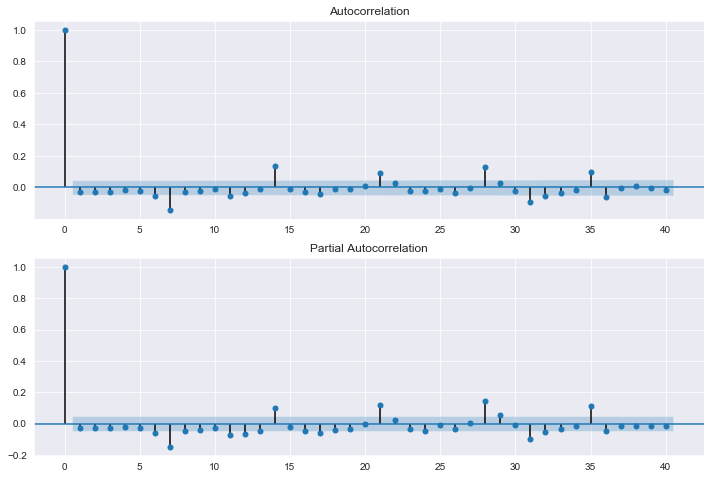

In [42]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

## Make prediction and evaluation

Take the last 30 days in training set as validation data

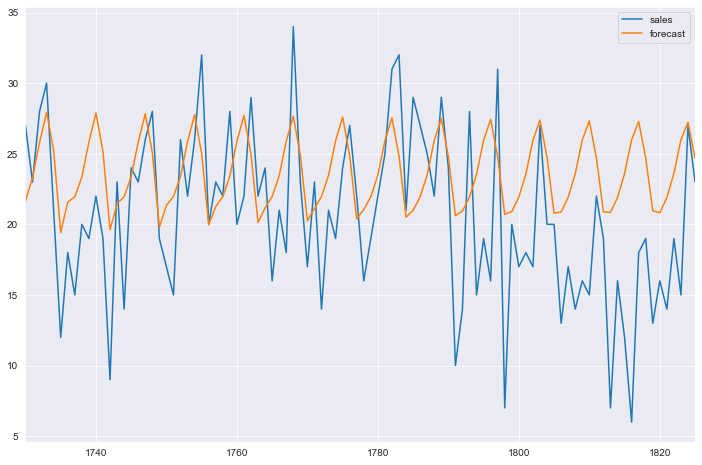

In [43]:
start_index = 1730
end_index = 1826

train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [36]:
train_df[train_df.date.duplicated()]

,date,store,item,sales,year,month,day,weekday


In [37]:
train_df.shape

(1826, 8)

In [20]:
test=pd.read_csv("test.csv",usecols=['date','store','item'])
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")
# per 1 store, 1 item
test_df = test[test['store']==1]
test_df=test_df[test_df['item']==1]
# train_df = train_df.set_index('date')
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.dayofyear
test_df['weekday'] = test_df['date'].dt.weekday
test_df.set_index('date')
print(test_df)

         date  store  item  year  month  day  weekday
0  2018-01-01      1     1  2018      1    1        0
1  2018-01-02      1     1  2018      1    2        1
2  2018-01-03      1     1  2018      1    3        2
3  2018-01-04      1     1  2018      1    4        3
4  2018-01-05      1     1  2018      1    5        4
..        ...    ...   ...   ...    ...  ...      ...
85 2018-03-27      1     1  2018      3   86        1
86 2018-03-28      1     1  2018      3   87        2
87 2018-03-29      1     1  2018      3   88        3
88 2018-03-30      1     1  2018      3   89        4
89 2018-03-31      1     1  2018      3   90        5

[90 rows x 7 columns]


In [21]:
test_df['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")
test_df.set_index('date').head()

,store,item,year,month,day,weekday
date,,,,,,
2018-01-01,1,1,2018,1,1,0
2018-01-02,1,1,2018,1,2,1
2018-01-03,1,1,2018,1,3,2
2018-01-04,1,1,2018,1,4,3
2018-01-05,1,1,2018,1,5,4


In [22]:
print(sarima_mod6.predict(start=1826,end=2190) )

2018-01-01    16.845946
2018-01-02    17.204741
2018-01-03    17.073020
2018-01-04    18.873595
2018-01-05    18.458846
                ...    
2018-12-27    19.117485
2018-12-28    19.117485
2018-12-29    19.117485
2018-12-30    19.117485
2018-12-31    19.117485
Freq: D, Length: 365, dtype: float64


In [29]:
df=pd.DataFrame(sarima_mod6.predict(start=1826,end=1900))
df.columns=['forecast']
df.index.names = ['date']
#df=sarima_mod6.predict(start=1826,end=2191) 
df['store']=1
df['item']=1
print(df.head())
df.to_csv('test_forecast.csv')


             forecast  store  item
date                              
2018-01-01  16.845946      1     1
2018-01-02  17.204741      1     1
2018-01-03  17.073020      1     1
2018-01-04  18.873595      1     1
2018-01-05  18.458846      1     1


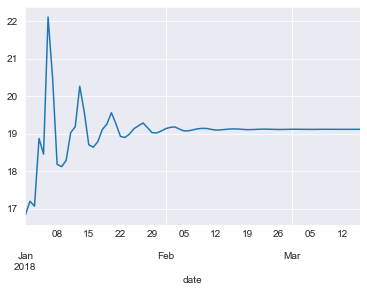

In [30]:
df['forecast'].plot()

In [24]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [25]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


## SARIMAX: adding external variables 

In [26]:
# per 1 store, 1 item
storeid = 1
itemid = 1
train_df = train[train['store']==storeid]
train_df = train_df[train_df['item']==itemid]

# train_df = train_df.set_index('date')
train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

start_index = 1730
end_index = 1826

# train_df.head()

In [27]:
holiday = pd.read_csv('../input/holiday/USholidays.csv',header=None, names = ['date', 'holiday'])
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True, format = '%y/%m/%d')
holiday.head()

FileNotFoundError: [Errno 2] File b'../input/holiday/USholidays.csv' does not exist: b'../input/holiday/USholidays.csv'

In [ ]:
train_df = train_df.merge(holiday, how='left', on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df, columns = ['month','holiday','weekday'] , prefix = ['month','holiday','weekday'])
# train_df.head()
# train_df.shape
# train_df.columns

In [ ]:
ext_var_list = ['date','year', 'day', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year Day', 'holiday_Presidents Day (Washingtons Birthday)',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [ ]:
exog_data = train_df[ext_var_list]
exog_data = exog_data.set_index('date')
exog_data.head()

In [ ]:
train_df = train_df.set_index('date')
# train_df = train_df.reset_index()
train_df.head()


In [ ]:
start_index = '2017-10-01'
end_index = '2017-12-31'
# exog_data.head()

In [ ]:
%%time
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                        exog = exog_data[:start_index],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

These model coefficients are not very reliable as most of them are not significant. This would imply a high collinearity between the data.  

In [ ]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

In [ ]:
sarimax_mod6.forecast(steps = 121,exog = exog_data[start_index:end_index])

In [ ]:
train_df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [ ]:
smape_kun(train_df[start_index:end_index]['sales'],train_df[start_index:end_index]['forecast'])

### Some last words:

ARIMA makes much more sense to me now. ACF and PACF are useful to determine the p, d, q. And each test is indeed helping me to justify whether I'm getting a better model or worse one. 


Pros:  
* Intepretability: Each coefficient means a specific thing
* ts key elements understanding: the concept of lags, and error lag terms are very unique, ARIMA gave a comprehensive cover on them. So even in the future I want to try some other regression model. I would add the lag terms and consider the error term. 

Cons:  
* Inefficiency: ARIMA needs to be run on each time series, since we have 500 store/item combinations, it needs to run 500 times. Every time we want to forecast the future, say on Jan 2, 2018, we want to forecast next 90 days. We need to re-run ARIMA. 

